# Импорты

In [1]:
! pip install sentencepiece transformers sacrebleu HeapDict -q 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 80.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.4 MB/s eta 0:00:00


In [2]:
! wget https://raw.githubusercontent.com/google/sentencepiece/master/src/sentencepiece_model.proto
! protoc --python_out=. sentencepiece_model.proto

--2023-05-16 07:39:27--  https://raw.githubusercontent.com/google/sentencepiece/master/src/sentencepiece_model.proto
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13845 (14K) [text/plain]
Saving to: ‘sentencepiece_model.proto’

sentencepiece_model 100%[===================>]  13.52K  --.-KB/s    in 0s      

2023-05-16 07:39:27 (120 MB/s) - ‘sentencepiece_model.proto’ saved [13845/13845]



In [3]:
import torch
from transformers import MBartForConditionalGeneration, MBart50Tokenizer
import json
from collections import Counter, defaultdict
from tqdm.auto import tqdm, trange
import random
import re
from copy import deepcopy
import pandas as pd

# Добавляю в модель токены бурятского языка

In [4]:
tokenizer = MBart50Tokenizer.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")

In [5]:
print(tokenizer.vocab_size)

250054


In [6]:
with open ('bur_all.txt', 'r', encoding='utf-8') as f:
   bur_all = f.readlines()

In [7]:
bur_all = set(bur_all)
len(bur_all)

203060

In [8]:
def get_tokens(text, tokenizer, verbose=False):
    toks = tokenizer.tokenize(text)
    words = []
    word = []
    prev_punct = False
    for tok in toks:
        is_punct = tok.lstrip(SPACE) and all(c in PUNCT for c in tok.lstrip(SPACE))
        if tok.startswith(SPACE) or prev_punct != is_punct:
            if word:
                words.append(word)
            word = []
        word.append(tok)
        prev_punct = is_punct
    if word:
        words.append(word)
    if verbose:
        print(words)
    res = words
    # assert tokenizer.decode([tok for t in res for tok in t]) == text
    return res

In [9]:
PUNCT = '.,-—:)(»«!?–/;„"“…*́№Ёҥ[]”^%+І=і•_􏰀²|}{#‘■>⁠’á<°\§\''
SPACE = '▁'
word_count = Counter()
word2toks = {}
for text in tqdm(bur_all):
    for word_toks in get_tokens(text, tokenizer):
        word = ''.join(word_toks)
        word_count[word] += 1
        word2toks[word] = word_toks
print(len(word_count))

  0%|          | 0/203060 [00:00<?, ?it/s]

465440


In [10]:
word_count2 = deepcopy(word_count)
word2toks2 = deepcopy(word2toks)

word_count = deepcopy(word_count2)
word2toks = deepcopy(word2toks2)

In [11]:
for k, v in word_count.most_common(30):
    if len(word2toks[k]) > 1:
        print(word2toks[k])

['▁гэж', 'э']
['▁h', 'эн']
['▁нэг', 'э']
['▁тэр', 'э']
['▁бай', 'h', 'ан']
['▁л', 'э']
['▁дээр', 'э']
['▁е', 'х', 'э']


In [12]:
steps = 100_000
min_count = 30  
extra_vocab = []
extra_counts = []
extra_pairs = []

In [13]:
pairs_count = Counter()
pair2word = defaultdict(set)
for w, c in tqdm(word_count.items(), total=len(word_count)):
    enc = word2toks[w]
    for pair in zip(enc[:-1], enc[1:]):
        pairs_count[pair] += c
        pair2word[pair].add(w)

  0%|          | 0/465440 [00:00<?, ?it/s]

In [14]:
from heapdict import heapdict
hd = heapdict()
for w, c in pairs_count.items():
    hd[w] = -c

In [15]:
def replace_pair(old_tokens, pair, new_token):
    result = []
    prev = old_tokens[0]
    for tok in old_tokens[1:]:
        if (prev, tok) == pair:
            result.append(new_token)
            prev = None
        else:
            if prev is not None:
                result.append(prev)
            prev = tok
    if prev is not None:
        result.append(prev)
    return result

In [16]:
for _ in trange(steps):
    #pair, c = pairs_count.most_common(1)[0]  # это самая времязатратная операция
    pair, c = hd.peekitem()
    c = -c
    
    if c < min_count:
        break
    new_token = ''.join(pair) # instead of BERT-like pair[0] + pair[1][2:]
    extra_vocab.append(pair)
    extra_counts.append(c)
    extra_pairs.append(pair)
    
    # update the vocabulary
    #new_id = len(id2ids)
    #tok2id[new_token] = new_id
    #id2ids.append(id2ids[tok2id[pair[0]]] + id2ids[tok2id[pair[1]]]) 
    
    # calculate the delta for the heap
    delta = Counter()
    for word in list(pair2word[pair]):
        # calculate old and new ways to tokenize the word
        old_toks = word2toks[word]
        # new_toks = " ".join(old_toks).replace(' '.join(pair), new_token).split(" ")
        new_toks = replace_pair(old_toks, pair, new_token)
        word2toks[word] = new_toks
        wc = word_count[word]
        # update the index concerning the tokens of the word
        for old_pair in zip(old_toks[:-1], old_toks[1:]):
            #pairs_count[old_pair] -= wc
            delta[old_pair] -= wc
            if word in pair2word[old_pair]:
                pair2word[old_pair].remove(word)
        for new_pair in zip(new_toks[:-1], new_toks[1:]):
            # pairs_count[new_pair] += wc
            delta[new_pair] += wc
            pair2word[new_pair].add(word)
    # update the heap
    for a_pair, a_delta in delta.items():
        if a_delta == 0:
            continue
        if a_pair not in hd:
            hd[a_pair] = 0
        hd[a_pair] -= a_delta

  0%|          | 0/100000 [00:00<?, ?it/s]

In [17]:
len(extra_pairs)

21810

In [18]:
extra_pairs[:10]

[('h', 'ан'),
 ('▁гэж', 'э'),
 ('h', 'эн'),
 ('х', 'э'),
 ('h', 'а'),
 ('б', 'э'),
 ('шь', 'е'),
 ('▁я', 'ба'),
 ('я', 'а'),
 ('h', 'аа')]

In [19]:
tokenizer.save_pretrained('old_tokenizer')

('old_tokenizer/tokenizer_config.json',
 'old_tokenizer/special_tokens_map.json',
 'old_tokenizer/sentencepiece.bpe.model',
 'old_tokenizer/added_tokens.json')

In [20]:
import sentencepiece_model_pb2 as model
m = model.ModelProto()
m.ParseFromString(open("old_tokenizer/sentencepiece.bpe.model", "rb").read())

5069051

In [21]:
scores = [p.score for p in m.pieces]
min_score = min(scores)
epsilon = 1e-4

In [22]:
for i, pair in enumerate(extra_vocab):
    new_token = model.ModelProto().SentencePiece()
    new_token.piece = ''.join(pair)
    new_token.score = min_score - epsilon * (i+1)
    m.pieces.append(new_token)

In [23]:
with open("old_tokenizer/sentencepiece.bpe.model", 'wb') as f:
    f.write(m.SerializeToString())

In [25]:
# tokenizer =  MBart50Tokenizer.from_pretrained(
#     "old_tokenizer/") 

RuntimeError: ignored

In [29]:
new_tokenizer = tokenizer

In [30]:
new_tokenizer.vocab_size

250054

7893 новых токенов

In [31]:
from transformers.models.mbart50.tokenization_mbart50 import FAIRSEQ_LANGUAGE_CODES

In [32]:
self = new_tokenizer

In [33]:
self.lang_code_to_id = {
    code: self.sp_model_size + i + self.fairseq_offset for i, code in enumerate(FAIRSEQ_LANGUAGE_CODES + ['bxr_XX'])
}
self.id_to_lang_code = {v: k for k, v in self.lang_code_to_id.items()}
self.fairseq_tokens_to_ids["<mask>"] = len(self.sp_model) + len(self.lang_code_to_id) + self.fairseq_offset

self.fairseq_tokens_to_ids.update(self.lang_code_to_id)
self.fairseq_ids_to_tokens = {v: k for k, v in self.fairseq_tokens_to_ids.items()}

In [34]:
new_tokenizer.additional_special_tokens.append('bxr_XX')

In [35]:
# +1 токен для обозначения языка
new_tokenizer.vocab_size

250055

In [36]:
tokenizer = MBart50Tokenizer.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")

In [37]:
print(tokenizer.tokenize(text))
print(new_tokenizer.tokenize(text))

['▁5', '28', 'уха', 'андаа', '▁оруул', 'аагүй', '▁юу', 'мэ', 'е', 'э', '▁дуу', 'гар', 'жар', 'хи', 'ба', '.']
['▁5', '28', 'уха', 'андаа', '▁оруул', 'аагүй', '▁юу', 'мэ', 'е', 'э', '▁дуу', 'гар', 'жар', 'хи', 'ба', '.']


In [38]:
random.seed(1)
sample = random.sample(bur_all, 10000)

<ipython-input-38-aaaef8a53f32>:2: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(bur_all, 10000)


In [39]:
# по 10к предложений статистика длины токенов
pd.DataFrame({
    'old': [len(tokenizer.tokenize(text)) for text in sample], 
    'new': [len(new_tokenizer.tokenize(text)) for text in sample]
}).describe()

,old,new
count,10000.000000,10000.000000
mean,54.807300,54.807300
std,74.959117,74.959117
min,2.000000,2.000000
25%,20.000000,20.000000
50%,35.000000,35.000000
75%,61.000000,61.000000
max,3162.000000,3162.000000


## Calculating tokens alignment

In [40]:
with open('train.json', 'r', encoding='utf-8') as f:
    all_pairs = json.load(f)

In [41]:
with open('back_translated.json', 'r') as f:
    back_translated = json.load(f)
translated_pairs = list(zip(back_translated['original'], back_translated['translated']))

In [42]:
random.choice(all_pairs)

['Буряад Уласай Засагай газарай 2022.04.07-ой №187 тогтоолоор БАТАЛАГДАА',
 '(тыс. рублей) УТВЕРЖДЕНО постановлением Правительства Республики Бурятия от 07.04.2022 № 187']

In [43]:
random.choice(translated_pairs)

('261                         Үглөөнэй наранаар эхэ нютагаа эрьен харахадам, Үнгэ бүриин дэльбэтэйҮзэсхэлэн hайхан сэсэгүүд амаршална намайе.Амар сайн, аглаг дайдымни сэсэгүүд!Бальжан гарма, тэмээн табгай, бамбагаа,Алаг нюдэн, сагаан дали, улаалзай —Эхэ нютагаймни шэмэг.Үрэжэлтэ газарай үрэ зүрхэнhөө түрэhэнИрагуу hайхан дуунууд мэтэлта.Эреэлнэ ногоорhон сэсэгтэ нугаяа харахадаа,Нюдэмни баясана,Хангал hайхан үнэрыень үнэсэн ябахадаа, Сэдьхэлни уярна.Үнгэрhэн сагта элдин таладаа үеэ тэнииhэнҮбгэ эсэгэнэрэймнай үрэ зүрхэнhөө ургаа ха гү?Али үе наhаараа үгытэй ядуу,Хараалта замбида хашагдаhан баhуулhанҺаруул hайхан сэдьхэлтэйДууша хүнэй алагхан нюдэнhөөМүндэлөө ха гү эдэ сэсэгүүд?...Хэрбээ тиимэ юм hаа,Һайхан лэ үбгэ эсэгэнэртэй байгаа хабди даа.\n',
 '261 Добро утро, родной мой, у меня цветутся лепестки красного голода. Откуда доброе и милые цветы! нежная трава, верблюд, розовый костер, глаза белые, крылатые — Родина 1940 года. Рожденные в селениях прекрасные песни о любви. Видя старую м

In [44]:
all_pairs += translated_pairs

In [45]:
'длина параллельного текста (предложения и слова) ', len(all_pairs)

('длина параллельного текста (предложения и слова) ', 47653)

In [46]:
from collections import defaultdict, Counter
token_priors = Counter()
token_to_others = defaultdict(Counter)

In [48]:
for bur, ru in tqdm(all_pairs):
    bur_toks = new_tokenizer.convert_tokens_to_ids(new_tokenizer.tokenize(bur))
    ru_toks = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(ru))
    token_priors.update(ru_toks)
    for bur_tok in bur_toks:
        token_to_others[bur_tok].update(ru_toks)

  0%|          | 0/47653 [00:00<?, ?it/s]

In [49]:
import numpy as np

def get_ru_toks(bxr_tok):
    ru_toks = []
    ru_weights = []
    for t, w in token_to_others[bxr_tok].items():
        ru_toks.append(t)
        ru_weights.append(w**2 / token_priors[t])
    ru_weights = np.array(ru_weights)
    ru_weights = ru_weights / (sum(ru_weights) + 1e-4)
    return ru_weights, ru_toks

In [50]:
bur, ru = random.choice(all_pairs)
bur, ru

('Площадь дээрэ хон жэн болобо.', 'Площадь опустела.')

In [51]:
print(new_tokenizer.convert_tokens_to_ids(new_tokenizer.tokenize(bur)))

[89007, 4653, 40535, 13349, 8618, 6, 49368, 2637, 8763, 2849, 113009, 5]


In [52]:
bur_token = 37976

In [53]:
sorted(zip(*get_ru_toks(bur_token)), reverse=True)[:5]

[(0.6349098684971944, 37976),
 (0.19436016382567178, 222149),
 (0.024295020478208973, 180079),
 (0.021595573758407975, 177462),
 (0.017669105802333798, 78917)]

In [54]:
tokenizer.convert_ids_to_tokens([37976, 222149, 42315,  17512, 49517])

['▁демократ', '▁демократия', 'изация', 'изм', 'ический']

## Updating the model embeddings

In [55]:
len(new_tokenizer)

250055

In [56]:
from transformers import MBartForConditionalGeneration, MBart50Tokenizer
model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")

In [57]:
model.model.shared

Embedding(250054, 1024, padding_idx=1)

In [58]:
# изменяем размер токенов
model.resize_token_embeddings(len(new_tokenizer))

Embedding(250055, 1024)

In [59]:
n_extra = len(extra_vocab)
print(n_extra)
old_vocab_size = len(tokenizer.sp_model) + 1

21810


In [60]:
old_vocab_size

250001

In [61]:
# токены, кодирующие язык "переместили" в конец по айди

for old_token_id in range(old_vocab_size, len(tokenizer)):
    old_token = tokenizer.convert_ids_to_tokens(old_token_id)
    new_token_id = new_tokenizer.convert_tokens_to_ids(old_token)
    
    print(old_token_id, old_token, new_token_id)
    # model.model.shared.weight.data[i + n_extra] = model.model.shared.weight.data[i]
    model.model.shared.weight.data[new_token_id] = model.model.shared.weight.data[old_token_id]

250001 ar_AR 250001
250002 cs_CZ 250002
250003 de_DE 250003
250004 en_XX 250004
250005 es_XX 250005
250006 et_EE 250006
250007 fi_FI 250007
250008 fr_XX 250008
250009 gu_IN 250009
250010 hi_IN 250010
250011 it_IT 250011
250012 ja_XX 250012
250013 kk_KZ 250013
250014 ko_KR 250014
250015 lt_LT 250015
250016 lv_LV 250016
250017 my_MM 250017
250018 ne_NP 250018
250019 nl_XX 250019
250020 ro_RO 250020
250021 ru_RU 250021
250022 si_LK 250022
250023 tr_TR 250023
250024 vi_VN 250024
250025 zh_CN 250025
250026 af_ZA 250026
250027 az_AZ 250027
250028 bn_IN 250028
250029 fa_IR 250029
250030 he_IL 250030
250031 hr_HR 250031
250032 id_ID 250032
250033 ka_GE 250033
250034 km_KH 250034
250035 mk_MK 250035
250036 ml_IN 250036
250037 mn_MN 250037
250038 mr_IN 250038
250039 pl_PL 250039
250040 ps_AF 250040
250041 pt_XX 250041
250042 sv_SE 250042
250043 sw_KE 250043
250044 ta_IN 250044
250045 te_IN 250045
250046 th_TH 250046
250047 tl_XX 250047
250048 uk_UA 250048
250049 ur_PK 250049
250050 xh_ZA 250050


~ 50 токенов для языков

Because we have added one more language, its id must be computed separately, e.g. as an average of related languages

In [62]:
model.model.shared.weight.data[new_tokenizer.convert_tokens_to_ids('bxr_XX')] = (
    model.model.shared.weight.data[tokenizer.convert_tokens_to_ids('mn_MN')] * 0.45
    + model.model.shared.weight.data[tokenizer.convert_tokens_to_ids('ru_RU')] * 0.45
)

Compute embeddings for newly added tokens

In [63]:
for i in trange(n_extra):
    bxr_tok = i + old_vocab_size
    ru_weights, ru_toks = get_ru_toks(bxr_tok)
    if len(ru_toks) > 0:
        new_embedding = (model.model.shared.weight.data[ru_toks].T * ru_weights).sum(1)
        model.model.shared.weight.data[bxr_tok] = new_embedding

  0%|          | 0/21810 [00:00<?, ?it/s]

In [64]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [65]:
# new_model_path = '/content/drive/MyDrive/ml_models/bxr/mbart-large-50-bxr-v0'

In [66]:
# model.save_pretrained(new_model_path)
# new_tokenizer.save_pretrained(new_model_path)

In [67]:
# !ls -alsh $new_model_path

# Обучение модели на машинный перевод

In [68]:
# from google.colab import drive
# drive.mount('/content/drive')

In [69]:
!pip install transformers sentencepiece sacrebleu -q

In [70]:
import os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm, trange
import json
import random
import torch
from transformers.optimization import Adafactor
from transformers import MBartForConditionalGeneration, MBart50Tokenizer

In [71]:
# base_model_path = '/content/drive/MyDrive/ml_models/bxr/mbart-large-50-bxr-v0'

In [72]:
# tokenizer = MBart50Tokenizer.from_pretrained(base_model_path)
# model = MBartForConditionalGeneration.from_pretrained(base_model_path)

tokenizer = new_tokenizer
# model = model

In [73]:
old_len = len(tokenizer)
old_len

250055

In [74]:
tokenizer.lang_code_to_id['bxr_XX'] = old_len-1
tokenizer.id_to_lang_code[old_len-1] = 'bxr_XX'
tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
if 'bxr_XX' not in tokenizer.additional_special_tokens:
    tokenizer.additional_special_tokens.append('bxr_XX')

In [75]:
import gc

def cleanup():
    gc.collect()
    torch.cuda.empty_cache()
    
cleanup()

In [76]:
model.cuda();

## First, update just the new embeddings

In [77]:
for p in model.parameters():
    p.requires_grad = False
for p in model.model.shared.parameters():
    p.requires_grad = True

In [78]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad], 
    scale_parameter=False, 
    relative_step=False, 
    lr=1e-5,
    clip_threshold=1.0
)

In [79]:
batch_size = 8  
report_steps = 500 
epochs = 4
losses = []

In [80]:
tokenizer.src_lang = "ru_RU"
tokenizer.tgt_lang = "bxr_XX"

In [81]:
cleanup()
model.train()

for epoch in range(epochs):
    print('EPOCH', epoch)
    random.shuffle(all_pairs)
    for i in trange(0, int(len(all_pairs) / batch_size)):
        batch = all_pairs[i * batch_size: (i + 1) * batch_size]
        # кодируем вопрос и ответ 
        x = tokenizer([p[1] for p in batch], return_tensors='pt', padding=True, truncation=True, max_length=256).to(model.device)
        with tokenizer.as_target_tokenizer():
            y = tokenizer([p[0] for p in batch], return_tensors='pt', padding=True, truncation=True, max_length=256).to(model.device)
        # -100 - специальное значение, позволяющее не учитывать токены
        y.input_ids[y.input_ids == 0] = -100
        # вычисляем функцию потерь
        try:
            loss = model(
                input_ids=x.input_ids,
                attention_mask=x.attention_mask,
                labels=y.input_ids,
                decoder_attention_mask=y.attention_mask,
                return_dict=True
            ).loss
            # делаем шаг градиентного спуска
            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
        except RuntimeError as e:
            print('error')
            loss = None
            optimizer.zero_grad(set_to_none=True)
            cleanup()
            continue

        # печатаем скользящее среднее значение функции потерь
        losses.append(loss.item())
        if i % report_steps == 0:
            print('step', i, 'loss', np.mean(losses[-report_steps:]))

EPOCH 0


  0%|          | 0/5956 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3606: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


step 0 loss 11.78807544708252
step 500 loss 7.261041706562042
step 1000 loss 2.4222366300821303
step 1500 loss 2.152054183125496
step 2000 loss 1.9862252214550973
step 2500 loss 1.8879481703042984
step 3000 loss 1.783840047955513
step 3500 loss 1.784573824763298
step 4000 loss 1.6840968772768974
step 4500 loss 1.6205798506736755
step 5000 loss 1.5801862246990204
step 5500 loss 1.566697073698044
EPOCH 1


  0%|          | 0/5956 [00:00<?, ?it/s]

step 0 loss 1.5318407356739043
step 500 loss 1.4765507913827896
step 1000 loss 1.413771530687809
step 1500 loss 1.4539427443742752
step 2000 loss 1.4105621874332428
step 2500 loss 1.380649227619171
step 3000 loss 1.4363280398845673
step 3500 loss 1.3705035232305527
step 4000 loss 1.3680256792902947
step 4500 loss 1.3614908777475356
step 5000 loss 1.3594503543376923
step 5500 loss 1.3103276081085204
EPOCH 2


  0%|          | 0/5956 [00:00<?, ?it/s]

step 0 loss 1.337297295808792
step 500 loss 1.2858124445676804
step 1000 loss 1.2876294751167296
step 1500 loss 1.263392131447792
step 2000 loss 1.3049893181324006
step 2500 loss 1.2634118482470513
step 3000 loss 1.2468127725124358
step 3500 loss 1.2301768769025803
step 4000 loss 1.249074606835842
step 4500 loss 1.233545943260193
step 5000 loss 1.222830299973488
step 5500 loss 1.2181104841828345
EPOCH 3


  0%|          | 0/5956 [00:00<?, ?it/s]

step 0 loss 1.2029695031046868
step 500 loss 1.2186796696782112
step 1000 loss 1.2001191049218178
step 1500 loss 1.1892058224081994
step 2000 loss 1.1898695251345635
step 2500 loss 1.1712221555113793
step 3000 loss 1.1803500745296478
step 3500 loss 1.1647666898369788
step 4000 loss 1.1753366801738738
step 4500 loss 1.156037923514843
step 5000 loss 1.1658434275984764
step 5500 loss 1.1520080677866935


In [82]:
# save_model_path = '/content/drive/MyDrive/ml_models/bxr/mbart-large-50-bxr-v11'

In [83]:
# model.save_pretrained(save_model_path)
# tokenizer.save_pretrained(save_model_path)

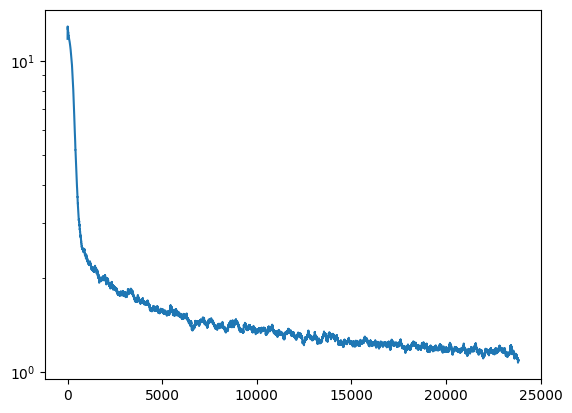

In [84]:
import matplotlib.pyplot as plt
pd.Series(losses).ewm(100).mean().plot();
plt.yscale('log');

# Now update the whole model, with embeddings and transformer layers.

In [85]:
# save_model_path = '/content/drive/MyDrive/ml_models/bxr/mbart-large-50-bxr-v11'

In [86]:
# model = MBartForConditionalGeneration.from_pretrained(save_model_path)
# tokenizer = MBart50Tokenizer.from_pretrained(save_model_path)

In [87]:
model.cuda();

In [88]:
loss = None
optimizer.zero_grad(set_to_none=True)
optimizer = None
cleanup()

In [89]:
for p in model.parameters():
    p.requires_grad = True

In [90]:
from transformers.optimization import Adafactor
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad], 
    scale_parameter=False, 
    relative_step=False, 
    lr=1e-6,
    clip_threshold=1.0
)

In [91]:
batch_size = 8
report_steps = 500 
epochs = 4
losses = []


Optimizing all parameters takes x2 longer than just embeddings: about 1h per epoch.

In [92]:
cleanup()
model.train()

for epoch in range(epochs):
    print('EPOCH', epoch)
    random.shuffle(all_pairs)
    for i in trange(0, int(len(all_pairs) / batch_size)):
        batch = all_pairs[i * batch_size: (i + 1) * batch_size]
        # кодируем вопрос и ответ 
        x = tokenizer([p[1] for p in batch], return_tensors='pt', padding=True, truncation=True, max_length=256).to(model.device)
        with tokenizer.as_target_tokenizer():
            y = tokenizer([p[0] for p in batch], return_tensors='pt', padding=True, truncation=True, max_length=256).to(model.device)
        # -100 - специальное значение, позволяющее не учитывать токены
        y.input_ids[y.input_ids == 0] = -100
        # вычисляем функцию потерь
        try:
            loss = model(
                input_ids=x.input_ids,
                attention_mask=x.attention_mask,
                labels=y.input_ids,
                decoder_attention_mask=y.attention_mask,
                return_dict=True
            ).loss
            # делаем шаг градиентного спуска
            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
        except RuntimeError as e:
            print('error')
            loss = None
            optimizer.zero_grad(set_to_none=True)
            cleanup()
            continue

        # печатаем скользящее среднее значение функции потерь
        losses.append(loss.item())
        if i % report_steps == 0:
            print('step', i, 'loss', np.mean(losses[-report_steps:]))

EPOCH 0


  0%|          | 0/5956 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3606: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


step 0 loss 1.0588572025299072
step 500 loss 1.1127823711037637
step 1000 loss 1.0852957809567452
step 1500 loss 1.096561305642128
step 2000 loss 1.0930037916600703
step 2500 loss 1.0846326129436492
step 3000 loss 1.056806948721409


KeyboardInterrupt: ignored

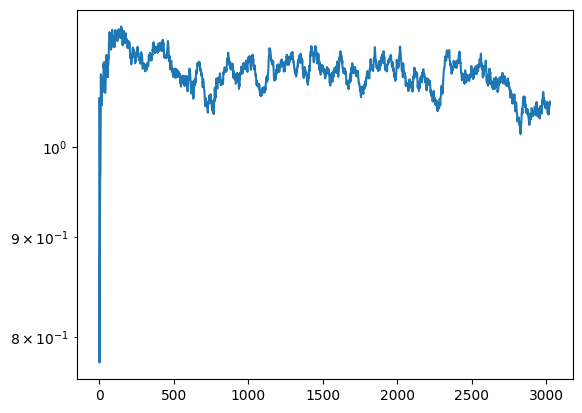

In [93]:
pd.Series(losses).ewm(100).mean().plot();
plt.yscale('log');

In [94]:
model.eval()

MBartForConditionalGeneration(
  (model): MBartModel(
    (shared): Embedding(250055, 1024)
    (encoder): MBartEncoder(
      (embed_tokens): Embedding(250055, 1024)
      (embed_positions): MBartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x MBartEncoderLayer(
          (self_attn): MBartAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): ReLU()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerNorm((1024,), eps=1e-05, elementw

In [95]:
bxr, ru = random.choice(all_pairs)
bxr, ru

('чинарын hүүдэр.', 'чинара.')

In [96]:
def translate(text, src='ru_RU', trg='bxr_XX', max_length=200, num_beams=5, repetition_penalty=5.0, **kwargs):
    tokenizer.src_lang = src
    encoded = tokenizer(text, return_tensors="pt")
    generated_tokens = model.generate(
        **encoded.to(model.device),
        forced_bos_token_id=tokenizer.lang_code_to_id[trg], 
        max_length=max_length, 
        num_beams=num_beams,
        repetition_penalty=repetition_penalty,
        # early_stopping=True,
    )
    return tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)[0]

translate(bxr)

'чинарын hүүдэр.'

In [97]:
import os
os.makedirs("mbart-large-50-bxr-v13")
model.save_pretrained("mbart-large-50-bxr-v13")

In [98]:
tokenizer.save_pretrained('mbart-large-50-bxr-v13')

('mbart-large-50-bxr-v13/tokenizer_config.json',
 'mbart-large-50-bxr-v13/special_tokens_map.json',
 'mbart-large-50-bxr-v13/sentencepiece.bpe.model',
 'mbart-large-50-bxr-v13/added_tokens.json')

In [99]:
with open('test.json', 'r') as f:
    test = json.load(f)

In [119]:
target = [bxr for bxr, ru in test]

In [117]:
translated = [translate(ru) for bxr, ru in tqdm(test)]

  0%|          | 0/1823 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [120]:
from sacrebleu import BLEU, CHRF
chrf = CHRF()
bleu = BLEU()

In [121]:
print('chrF: ', chrf.corpus_score(translated, target).score,
      'BLEU: ', bleu.corpus_score(translated, target).score)

chrF:  4.411764705882352 BLEU:  0.7762449678617828


In [122]:
print('библия',
      'chrF: ', chrf.corpus_score(translated[:751], target[:751]).score,
      'BLEU: ', bleu.corpus_score(translated[:751], target[:751]).score)
print('книги',
      'chrF: ', chrf.corpus_score(translated[751:1277], target[751:1277]).score,
      'BLEU: ', bleu.corpus_score(translated[751:1277], target[751:1277]).score)
print('tatoeba',
      'chrF: ', chrf.corpus_score(translated[1277:1364], target[1277:1364]).score,
      'BLEU: ', bleu.corpus_score(translated[1277:1364], target[1277:1364]).score)
print('стихи',
      'chrF: ', chrf.corpus_score(translated[1364:1527], target[1364:1527]).score,
      'BLEU: ', bleu.corpus_score(translated[1364:1527], target[1364:1527]).score)
print('Википедия',
      'chrF: ', chrf.corpus_score(translated[1527:1716], target[1527:1716]).score,
      'BLEU: ', bleu.corpus_score(translated[1527:1716], target[1527:1716]).score)
print('законы',
      'chrF: ', chrf.corpus_score(translated[1716:], target[1716:]).score,
      'BLEU: ', bleu.corpus_score(translated[1716:], target[1716:]).score)

библия chrF:  3.888299752562743 BLEU:  0.1696222319443435
книги chrF:  10.56338028169014 BLEU:  0.9178248246402589
tatoeba chrF:  18.918918918918916 BLEU:  1.7354371729873994
стихи chrF:  8.771929824561402 BLEU:  1.1158754615530424
Википедия chrF:  5.248284214775939 BLEU:  0.19505961211904183
законы chrF:  3.2397408207343408 BLEU:  0.7005953383943448


In [114]:
for i in range(len(test)):
  if i%50==0:
        print(int(i/50)+1, ') ', test[i][1])
        print('эталон: ', test[i][0])
        print('перевод: ', translated[i])
        print()

1 )  Ибо вы, люди разумные, охотно терпите неразумных:
эталон:  Таанад өөhэдөө ехэл сэсэн ухаантай, тиин тэнэг үбэштэй зондо ехэл тэсэбэритэй байдаг ха юмта!
перевод:  Юундэб гэхэдэ, таанад hүзэглэгшэд хүнүүд юм.Тиимэhээ тэнэг юумэнүүдые тэсэхэ дуратай байнат.

2 )  Тогда он закричал: Иисус, Сын Давидов! помилуй меня.
эталон:  Тиихэдэнь hохор хүн: «Давидай үри hадаhан Иисус, намайе үршөөжэ хайрлыш!» – гэжэ хашхарба. 
перевод:  Тиихэдэнь Иисус: «Иисус, Давидай Хүбүүн! Намайе хайрлажа байгты», – гэжэ хашхаралдаба.

3 )  Истинно говорю вам: не прейдет род сей, как все сие будет;
эталон:  Мүнөө ажамидаржа байhан хүнүүдэй бултанайнь үхэжэ үрдеэгүй байхада минии таанадта хэлэhэн бүхэн тохёолдохо гэжэ таанадта баталан хэлэнэб.
перевод:  Тиимэhээ би таанадта үнэн зүбөөр хэлэбэ: «Бурханай бүлгэм энэ дэлхэйн бүхы юумэнүүдээр дамжан байхагүй», – гэбэ.

4 )  И Я даю им жизнь вечную, и не погибнут вовек; и никто не похитит их из руки Моей.
эталон:  Би тэдэндэ мүнхэ наhа үгэнэб, тэдэ хэзээшье хосорх

In [ ]:
for i in range(len(test)):
  print(translated[i])

In [110]:
with open('translated_ru_bxr.txt', 'w', encoding='utf-8') as f:
  for i in translated:
    f.write(f'{i}\n')

# Evaluate